# CRISP-DM Framework for Predicting Hostel Prices on UCC Campus


## 1. Business Understanding

* **Objective:** To develop a predictive pricing model for hostels on the University of Cape Coast (UCC) campus, enabling students and stakeholders to make data-driven accommodation decisions.
* **Business Goals:**

  * Understand the determinants of hostel pricing.
  * Provide a reliable tool to forecast hostel prices based on selected features.
  * Support equitable pricing and informed budget planning for students.


## 2. Data Understanding

In [30]:
# import packages


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


In [4]:
#import dataset
df = pd.read_csv('../data/hostel_prices.csv')
df.head()

,gender,age_group,level_of_study,lecture_location,accommodation_type,faculty,off_campus_duration,room_category,annual_rent,includes_water,...,room_size,furnished_bed,furnished_table,furnished_chairs,has_access_controls,has_janitorial_services,required_deposit,recent_rent_increase,avg_rent_nearby,hostel_location
0,Male,25-30,Postgraduate,Science,2 in a room,Faculty of Social Sciences,Less than 6 months,Shared washroom- shared kitchen,4000.0,No,...,20 - 30 sqm,Yes,Yes,Yes,Yes,No,2500.0,500.0,5000.0,Kwaprow
1,Male,35-40,Postgraduate,New Site,Private room(1 in a room),School of Business,3 years or more,Full self contain,5000.0,Yes,...,15 - 20 sqm,Yes,NaN,NaN,No,No,2500.0,1500.0,4000.0,Amamoma
2,Male,25-30,Postgraduate,Science,Private room(1 in a room),Faculty of Social Sciences,6 months to 1 year,Full self contain,4500.0,No,...,15 - 20 sqm,Yes,Yes,Yes,No,No,2500.0,1000.0,3500.0,Domeabra
3,Male,26-30,Post Graduate,Science,5+ in a room,Faculty of Education,Between a year and 2 years,Shared washroom- No kitchen,5000.0,Yes,...,20 - 30 sqm,Yes,No,No,No,No,NaN,NaN,NaN,NaN
4,Male,26-30,Fourth year,Science,2 in a room,Faculty of Education,Between a year and 2 years,Full self contain,3000.0,No,...,20 - 30 sqm,No,No,No,No,No,NaN,NaN,NaN,Apewosika


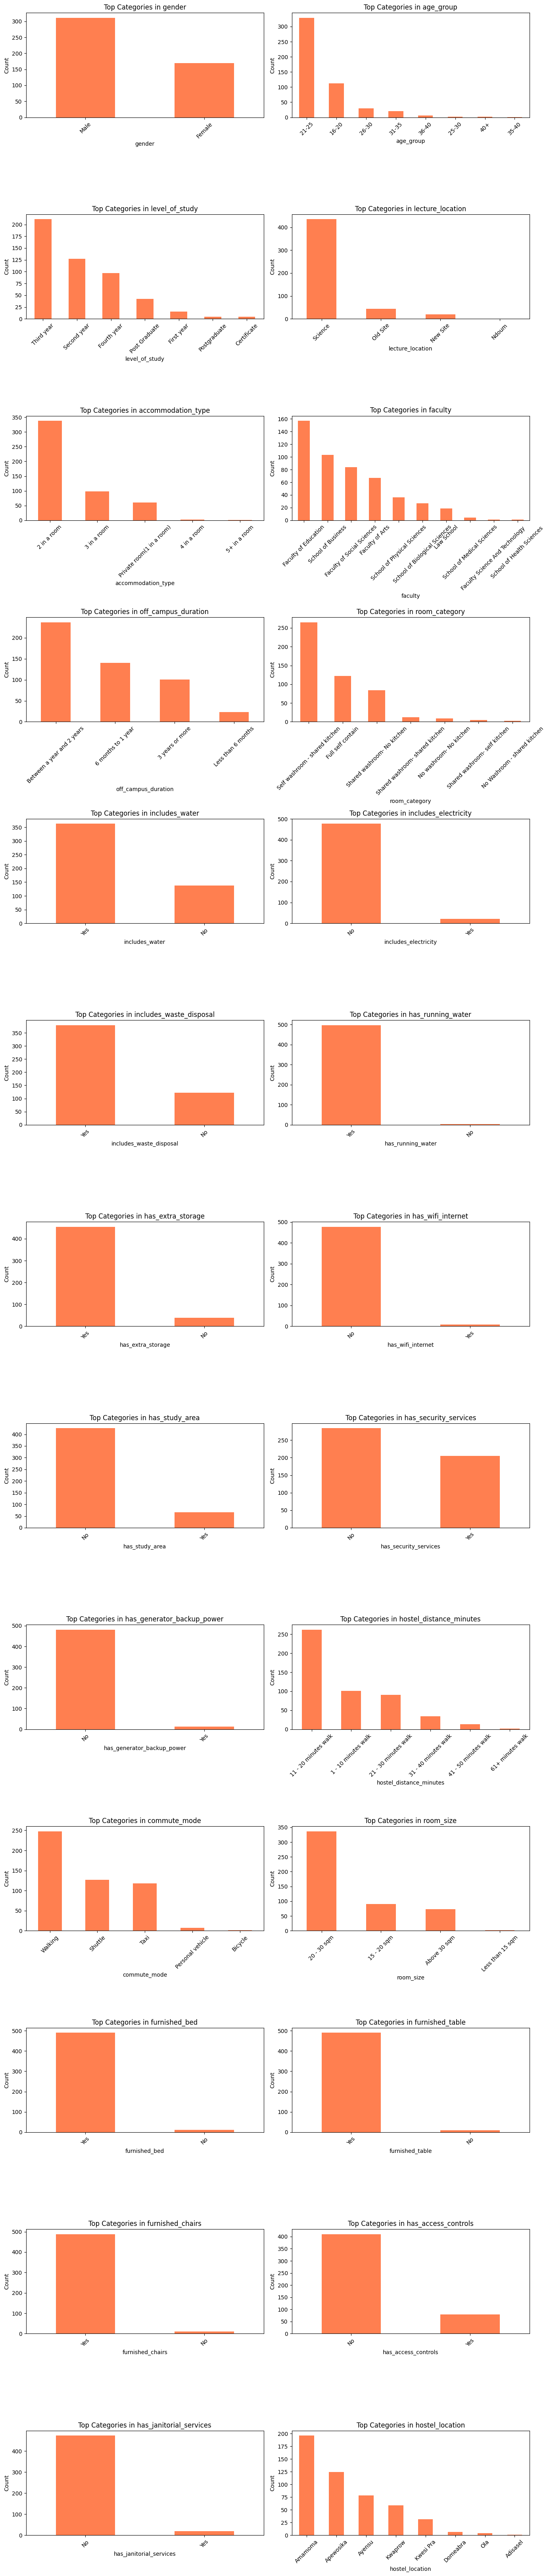

In [5]:


# Select categorical columns
categorical_cols = df.select_dtypes(include='object').columns
num_plots = len(categorical_cols)

# Define number of columns and rows for the subplot grid
cols = 2
rows = math.ceil(num_plots / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
axes = axes.flatten()  # Flatten in case it's a 2D array

# Plot each bar chart
for i, col in enumerate(categorical_cols):
    df[col].value_counts().head(10).plot(kind='bar', color='coral', ax=axes[i])
    axes[i].set_title(f"Top Categories in {col}")
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplot axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# Set plot style
sns.set(style="whitegrid")



In [6]:
# Summary of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   gender                      480 non-null    object 
 1   age_group                   502 non-null    object 
 2   level_of_study              500 non-null    object 
 3   lecture_location            500 non-null    object 
 4   accommodation_type          501 non-null    object 
 5   faculty                     501 non-null    object 
 6   off_campus_duration         501 non-null    object 
 7   room_category               500 non-null    object 
 8   annual_rent                 500 non-null    float64
 9   includes_water              500 non-null    object 
 10  includes_electricity        499 non-null    object 
 11  includes_waste_disposal     501 non-null    object 
 12  has_running_water           500 non-null    object 
 13  has_extra_storage           494 non

### 🧹 **Data Quality Insights**

1. **Missing Values**
   Several columns have missing (null) values:

   * `gender`: 22 missing
   * `level_of_study`: 2 missing
   * `lecture_location`: 2 missing
   * `accommodation_type`: 1 missing
   * `faculty`: 1 missing
   * `room_category`: 2 missing
   * `annual_rent`: 2 missing
   * `includes_water`: 2 missing
   * `includes_electricity`: 3 missing
   * `has_running_water`: 2 missing
   * `has_extra_storage`: 8 missing
   * `has_wifi_internet`: 16 missing
   * `has_study_area`: 9 missing
   * `has_security_services`: 13 missing
   * `has_generator_backup_power`: 9 missing
   * `furnished_table`: 2 missing
   * `furnished_chairs`: 3 missing
   * `has_access_controls`: 12 missing
   * `has_janitorial_services`: 10 missing
   * `required_deposit`: 2 missing
   * `recent_rent_increase`: 8 missing
   * `avg_rent_nearby`: 5 missing
   * `hostel_location`: 3 missing

2. **Inconsistent Data Types**

   * Some columns that represent numerical values (like `hostel_distance_minutes`) are stored as `object`, which could indicate inconsistent formatting (e.g., "10 minutes" instead of a numeric value).

3. **Potential Categorical Misclassification**

   * Many `object` columns may be better treated as categorical for analysis and memory optimization.

4. **Non-Standardized Entries Likely**

   * Free-text or categorical columns (e.g., `room_category`, `commute_mode`, `hostel_location`) may contain inconsistent spellings or capitalization, which can affect grouping and analysis.

5. **Data Completeness**

   * Most columns are well-filled, but columns with over 10 missing entries (e.g., `gender`, `has_wifi_internet`, `has_security_services`) may require imputation or exclusion depending on analysis goals.




In [7]:
# Shape of dataset
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")


Dataset contains 502 rows and 30 columns.


In [8]:
# Get columns by type
categorical_cols = df.select_dtypes(include='object').columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical Columns:")
print(categorical_cols)

print("\nNumerical Columns:")
print(numerical_cols)


Categorical Columns:
['gender', 'age_group', 'level_of_study', 'lecture_location', 'accommodation_type', 'faculty', 'off_campus_duration', 'room_category', 'includes_water', 'includes_electricity', 'includes_waste_disposal', 'has_running_water', 'has_extra_storage', 'has_wifi_internet', 'has_study_area', 'has_security_services', 'has_generator_backup_power', 'hostel_distance_minutes', 'commute_mode', 'room_size', 'furnished_bed', 'furnished_table', 'furnished_chairs', 'has_access_controls', 'has_janitorial_services', 'hostel_location']

Numerical Columns:
['annual_rent', 'required_deposit', 'recent_rent_increase', 'avg_rent_nearby']


In [9]:
# View unique values in each categorical column
for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(df[col].value_counts(dropna=False))



Column: gender
gender
Male      311
Female    169
NaN        22
Name: count, dtype: int64

Column: age_group
age_group
21-25    329
16-20    112
26-30     29
31-35     21
36-40      6
25-30      2
40+        2
35-40      1
Name: count, dtype: int64

Column: level_of_study
level_of_study
Third year       211
Second year      127
Fourth year       97
Post Graduate     42
First year        15
Postgraduate       4
Certificate        4
NaN                2
Name: count, dtype: int64

Column: lecture_location
lecture_location
Science     435
Old Site     44
New Site     20
NaN           2
Ndoum         1
Name: count, dtype: int64

Column: accommodation_type
accommodation_type
2 in a room                  338
3 in a room                   98
Private room(1 in a room)     61
4 in a room                    3
5+ in a room                   1
NaN                            1
Name: count, dtype: int64

Column: faculty
faculty
Faculty of Education               157
School of Business               

In [10]:
# Summary stats
print(df[numerical_cols].describe())


        annual_rent  required_deposit  recent_rent_increase  avg_rent_nearby
count    500.000000        500.000000            494.000000       497.000000
mean    2896.400000       1950.300000            544.878543      2622.720322
std     1418.644474       1080.240134            386.140582      1853.352141
min      400.000000        200.000000              0.000000       190.000000
25%     2000.000000       1200.000000            400.000000      1680.000000
50%     2500.000000       1550.000000            500.000000      2145.000000
75%     3000.000000       2000.000000            500.000000      3000.000000
max    12000.000000       7000.000000           4200.000000     30000.000000


#### 📊 **Insights from the Descriptive Statistics**

#### 1. **Annual Rent**

* **Count**: 500 entries — relatively complete.
* **Mean (Average)**: GH₵ 2,896 — the average rent students are paying annually.
* **Std (Standard Deviation)**: GH₵ 1,418 — there’s significant variability in rent amounts.
* **Min–Max**: GH₵ 400 to GH₵ 12,000 — some students pay extremely low or very high rents, indicating a wide disparity in accommodation types.
* **Interquartile Range (IQR)**:

  * 25th percentile (Q1): GH₵ 2,000
  * Median (Q2): GH₵ 2,500
  * 75th percentile (Q3): GH₵ 3,000
  * → Most students pay between GH₵ 2,000 and GH₵ 3,000 per year.

#### 2. **Required Deposit**

* **Count**: 500 — complete data.
* **Mean**: GH₵ 1,950 — the average one-time deposit required for accommodation.
* **Std**: GH₵ 1,080 — moderate variability in deposit values.
* **Min–Max**: GH₵ 200 to GH₵ 7,000 — some accommodations require steep upfront payments.
* **IQR**:

  * Q1: GH₵ 1,200
  * Median: GH₵ 1,550
  * Q3: GH₵ 2,000
  * → Half of the students pay between GH₵ 1,200 and GH₵ 2,000 in deposits.

#### 3. **Recent Rent Increase**

* **Count**: 494 — 6 missing entries.
* **Mean**: GH₵ 545 — on average, rent has increased by over GH₵ 500 recently.
* **Std**: GH₵ 386 — wide variation in how much rent has increased.
* **Min–Max**: GH₵ 0 to GH₵ 4,200 — some students have seen no increase, while others experienced large hikes.
* **IQR**:

  * Q1: GH₵ 400
  * Median: GH₵ 500
  * Q3: GH₵ 500
  * → Most rent increases are clustered around GH₵ 500.

#### 4. **Average Rent Nearby**

* **Count**: 497 — 5 missing entries.
* **Mean**: GH₵ 2,623 — average rent in nearby hostels.
* **Std**: GH₵ 1,853 — very high variation, suggesting a diverse market.
* **Min–Max**: GH₵ 190 to GH₵ 30,000 — a few extremely high values skew the range.
* **IQR**:

  * Q1: GH₵ 1,680
  * Median: GH₵ 2,145
  * Q3: GH₵ 3,000
  * → Most nearby options fall between GH₵ 1,680 and GH₵ 3,000.

---

### 💡 **Summary of Key Insights**

* There is **high variability** in rent and deposit amounts, reflecting a **diverse accommodation market** in terms of quality, location, or facilities.
* **Typical students** pay **GH₵ 2,000–3,000** annually and make a **deposit of around GH₵ 1,500–2,000**.
* Recent rent increases are **moderate to significant**, mostly **around GH₵ 500**, which may indicate inflation or market shifts.
* A few **extreme outliers** (e.g., rent as high as GH₵ 30,000 nearby) **inflate the mean**, so **median values give a better picture** of what most students face.




In [11]:
# Check missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_report = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
}).sort_values(by='Missing Values', ascending=False)

print("\nMissing Values Report:")
print(missing_report)



Missing Values Report:
                            Missing Values  Percentage
gender                                  22    4.382470
has_wifi_internet                       16    3.187251
has_security_services                   13    2.589641
has_access_controls                     12    2.390438
has_janitorial_services                 10    1.992032
has_study_area                           9    1.792829
has_generator_backup_power               9    1.792829
recent_rent_increase                     8    1.593625
has_extra_storage                        8    1.593625
avg_rent_nearby                          5    0.996016
includes_electricity                     3    0.597610
hostel_location                          3    0.597610
furnished_chairs                         3    0.597610
room_category                            2    0.398406
level_of_study                           2    0.398406
lecture_location                         2    0.398406
furnished_table                          

Here’s a clear and concise summary of the **insights from your missing values report**:

---

### 🧹 **Missing Values Insights**

1. **Overall Data Quality is High**

   * Most columns have **less than 2% missing values**, indicating that the dataset is generally well-maintained.
   * Only a few variables exceed **3%** in missingness, which is still manageable for analysis.

2. **Columns with Most Missing Values**

   * `gender` (22 missing, **4.38%**) has the highest missing rate and may require **imputation** or **exclusion** based on its importance.
   * `has_wifi_internet` (16 missing, **3.19%**) and `has_security_services` (13 missing, **2.59%**) are key variables related to facility availability and should be treated carefully.

3. **Groupings of Missingness**

   * A notable number of missing values are in columns related to **facilities and amenities**, such as:

     * `has_wifi_internet`
     * `has_security_services`
     * `has_access_controls`
     * `has_study_area`
     * `has_generator_backup_power`
     * `has_extra_storage`
   * This may suggest that some **respondents skipped detailed facility-related questions**, possibly due to unfamiliarity or lack of attention.

4. **Financial and Rent-Related Columns Are Mostly Complete**

   * Key numeric columns such as:

     * `annual_rent` (2 missing)
     * `required_deposit` (2 missing)
     * `recent_rent_increase` (8 missing)
     * `avg_rent_nearby` (5 missing)
       have very **low missing rates**, ensuring **reliable financial analysis**.

5. **Demographics and Location Data Are Almost Fully Filled**

   * `age_group`, `furnished_bed`, `hostel_distance_minutes`, and `room_size` are **100% complete**, which supports solid segmentation or clustering.

6. **Actionable Recommendation**

   * Columns with <2% missing can be **safely imputed** using techniques like mode (for categorical) or median (for numerical).
   * Columns over 3% (e.g., `gender`, `has_wifi_internet`) may need **closer review** — e.g., check for patterns of missingness or survey design issues.




In [12]:
# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_rows}")



Number of duplicate rows: 5


### **EDA**

#### **1️⃣ Distribution of  Numerical Variables**



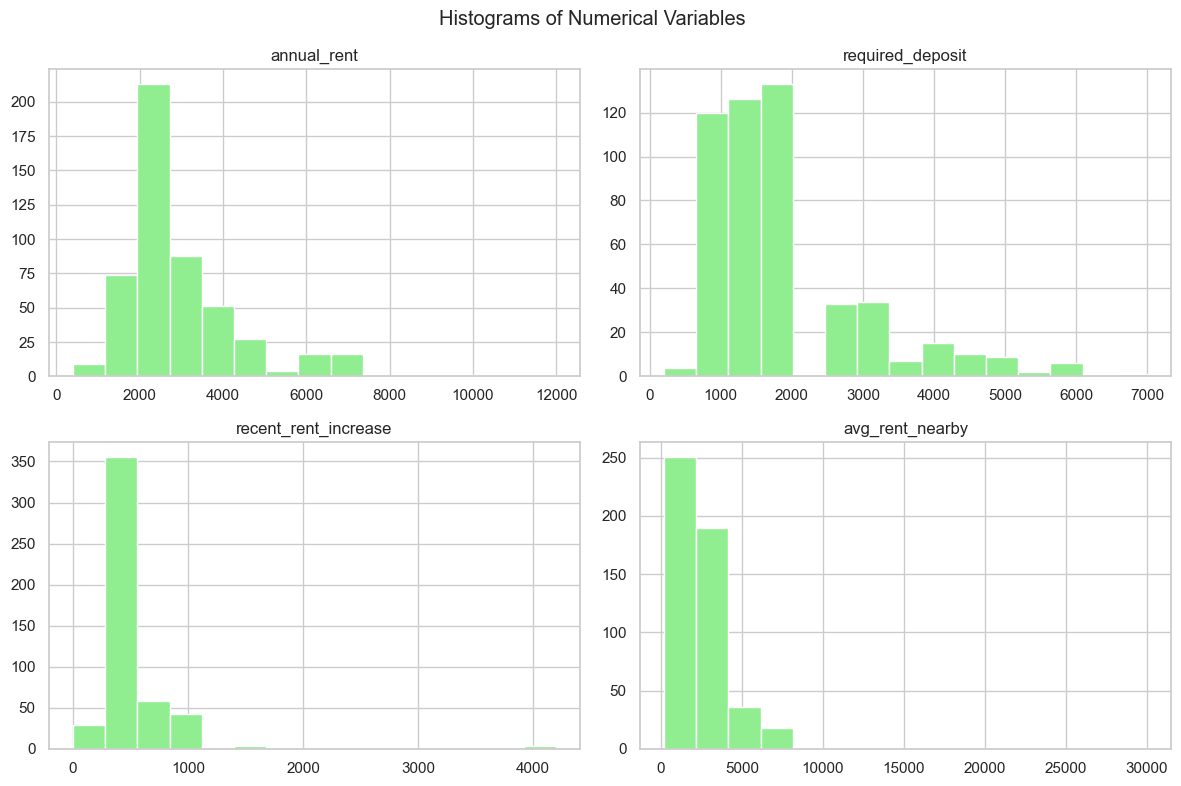

In [13]:
numerical_cols = ['annual_rent', 'required_deposit', 'recent_rent_increase', 'avg_rent_nearby']

df[numerical_cols].hist(bins=15, figsize=(12, 8), color='lightgreen')
plt.suptitle("Histograms of Numerical Variables")
plt.tight_layout()
plt.show()


#### **2️⃣ Categorical Variables – Frequency Counts**

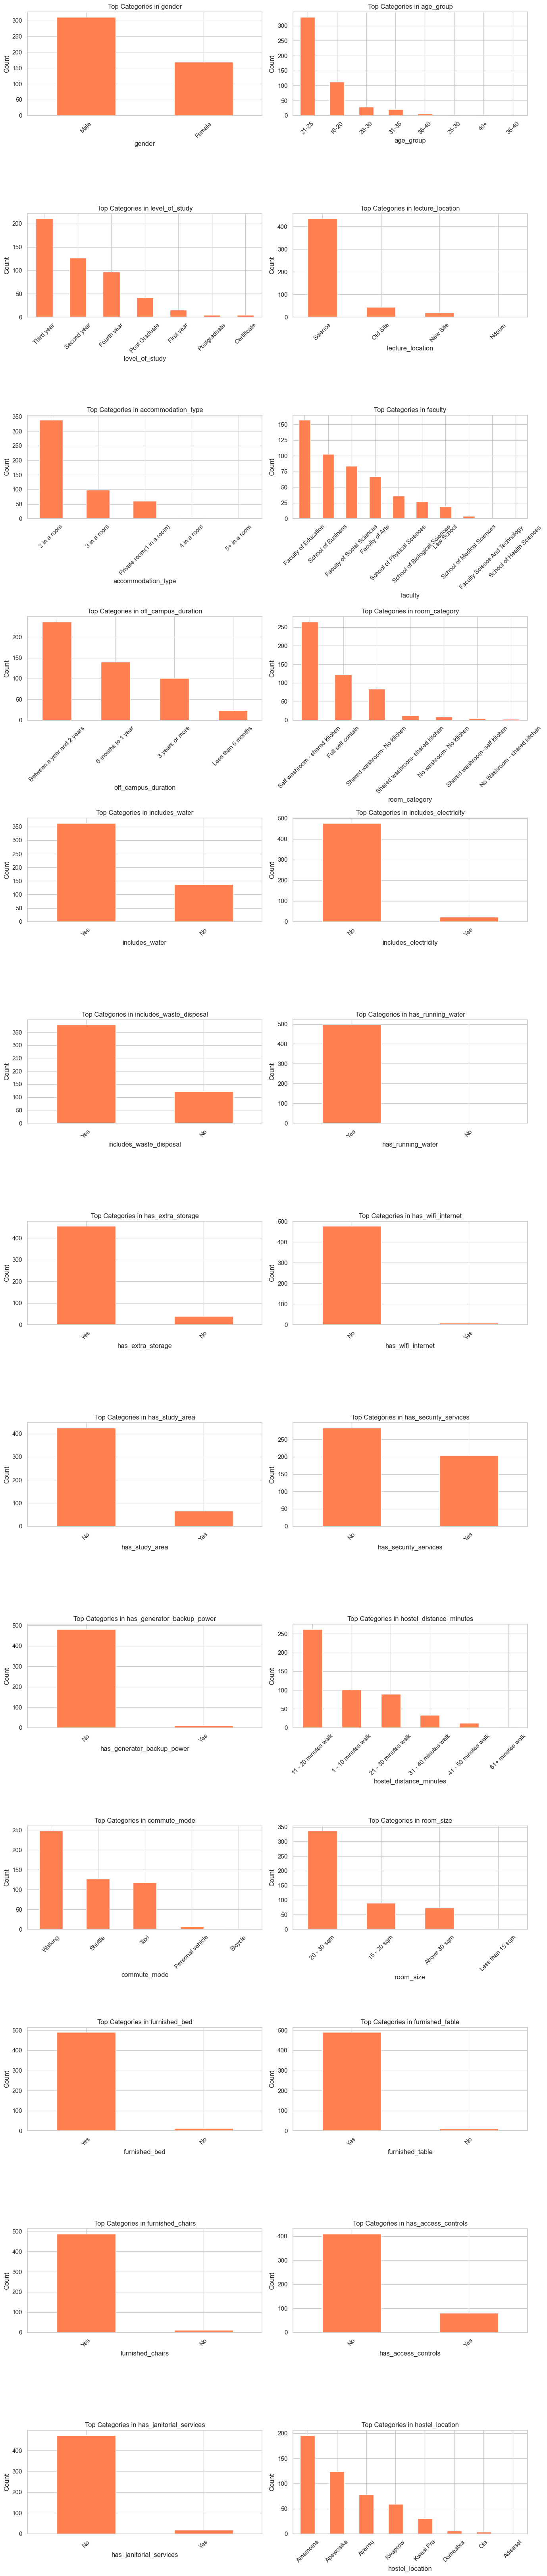

In [14]:


# Select categorical columns
categorical_cols = df.select_dtypes(include='object').columns
num_plots = len(categorical_cols)

# Define number of columns and rows for the subplot grid
cols = 2
rows = math.ceil(num_plots / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
axes = axes.flatten()  # Flatten in case it's a 2D array

# Plot each bar chart
for i, col in enumerate(categorical_cols):
    df[col].value_counts().head(10).plot(kind='bar', color='coral', ax=axes[i])
    axes[i].set_title(f"Top Categories in {col}")
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplot axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### **3️⃣ Boxplots: Categorical Features vs. annual_rent**

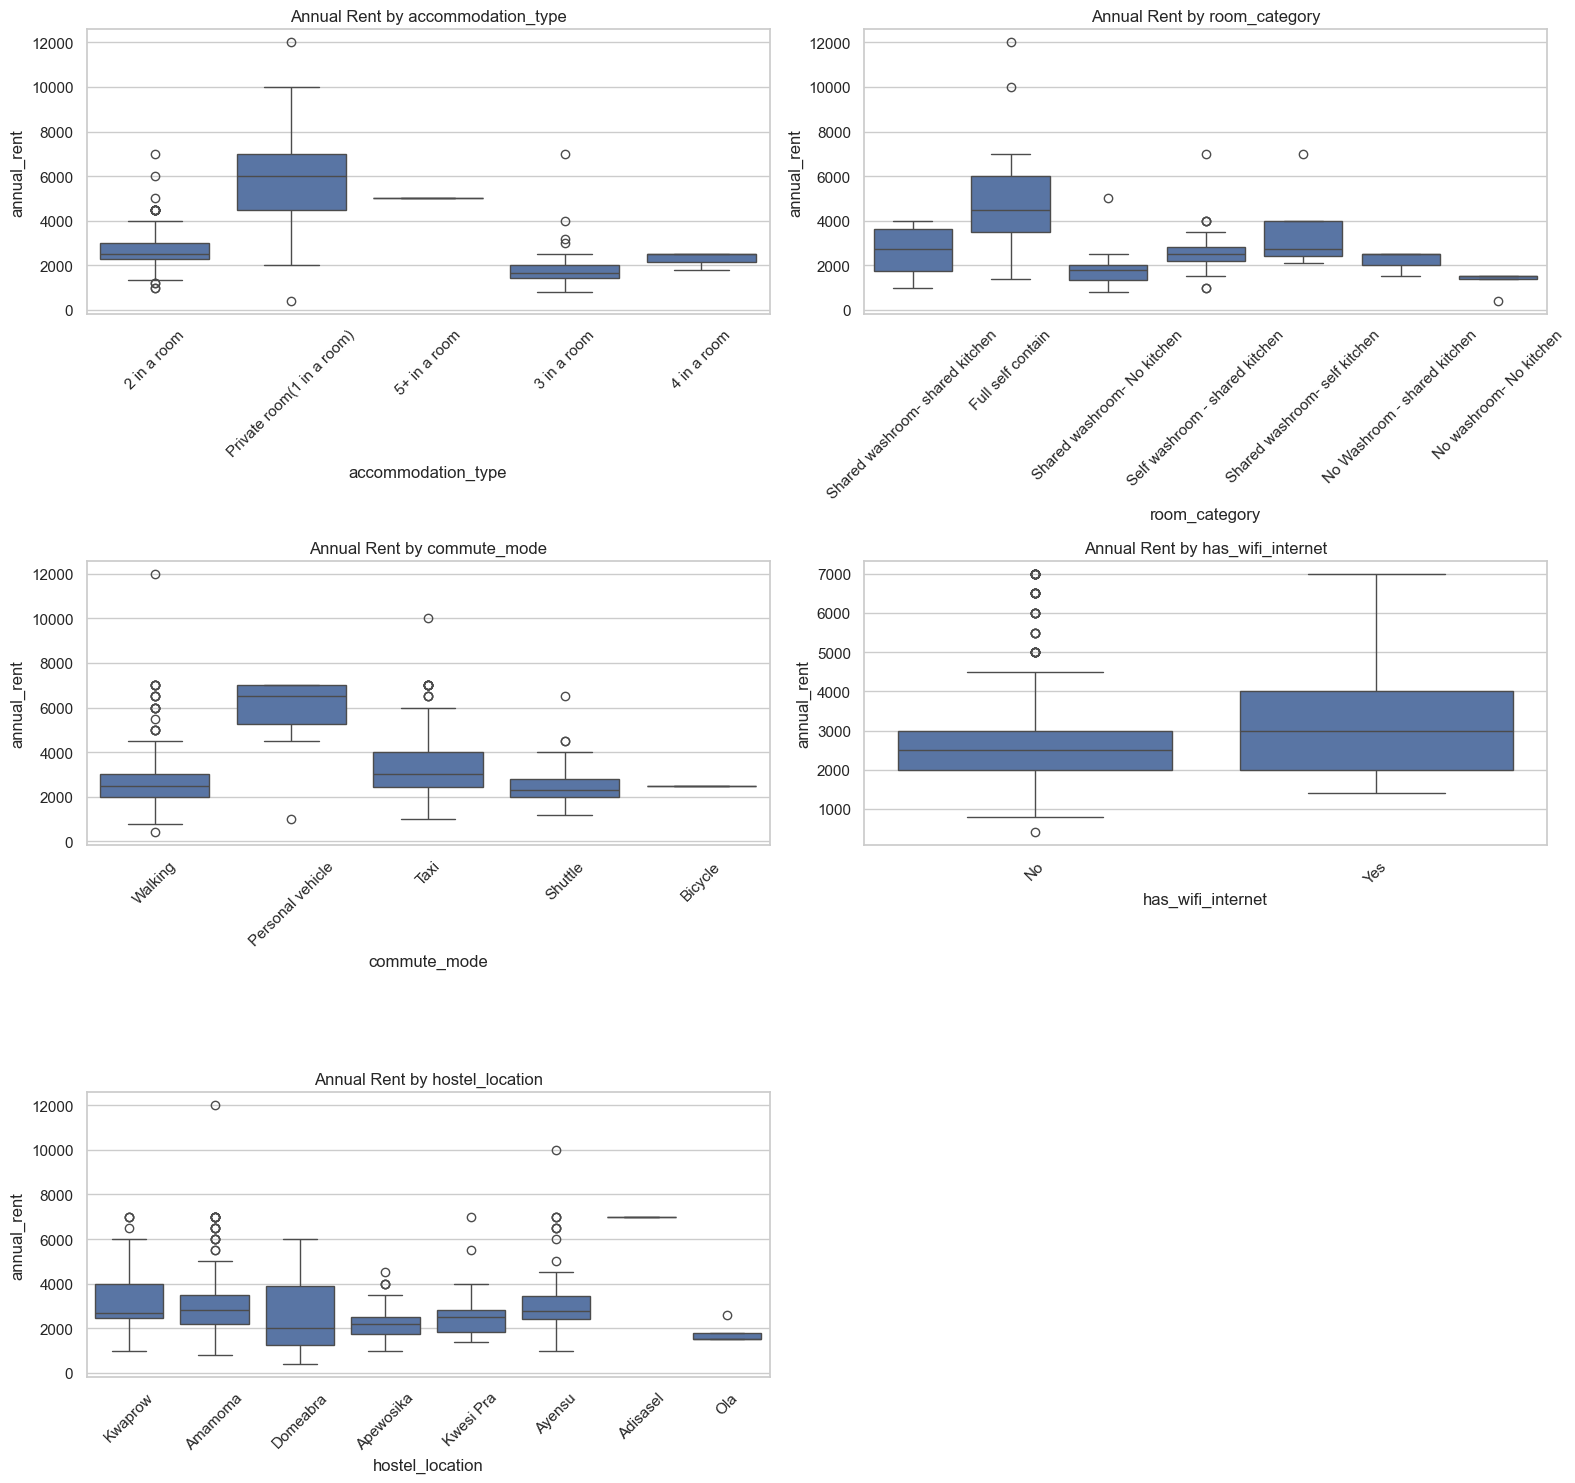

In [15]:
features_to_plot = ['accommodation_type', 'room_category', 'commute_mode', 'has_wifi_internet', 'hostel_location']
num_plots = len(features_to_plot)

# Set layout: 2 plots per row
cols = 2
rows = math.ceil(num_plots / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(16, 5 * rows))
axes = axes.flatten()

# Plot boxplots
for i, feature in enumerate(features_to_plot):
    sns.boxplot(x=df[feature], y=df['annual_rent'], ax=axes[i])
    axes[i].set_title(f"Annual Rent by {feature}")
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### 4️⃣ **Correlation Matrix for Numerical Variables**

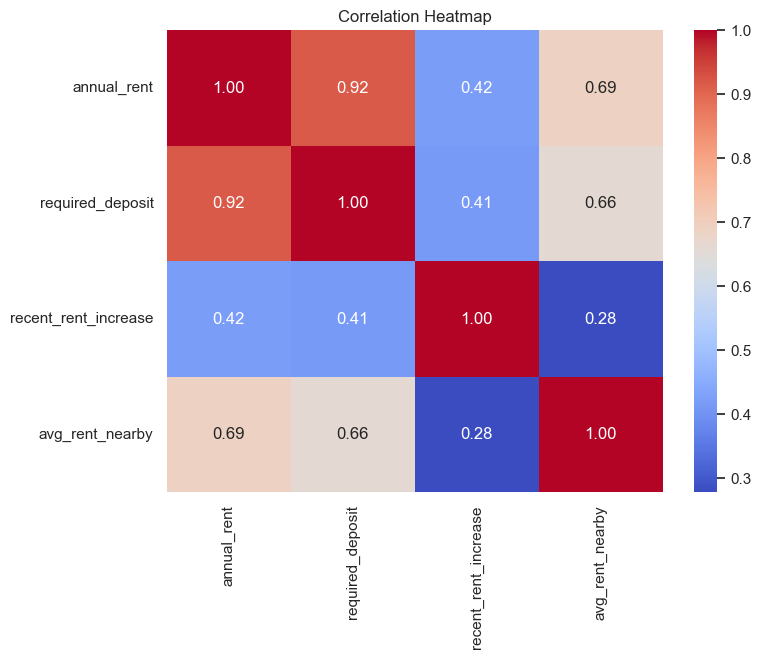

In [16]:
plt.figure(figsize=(8, 6))
corr_matrix = df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()


## ✅ **3. Data Preparation – Code Implementation**

#### **🧹 A. Data Cleaning**

In [18]:
# Check missing values
missing = df.isnull().sum()
print("Missing values:\n", missing[missing > 0])


Missing values:
 gender                        22
level_of_study                 2
lecture_location               2
accommodation_type             1
faculty                        1
off_campus_duration            1
room_category                  2
annual_rent                    2
includes_water                 2
includes_electricity           3
includes_waste_disposal        1
has_running_water              2
has_extra_storage              8
has_wifi_internet             16
has_study_area                 9
has_security_services         13
has_generator_backup_power     9
commute_mode                   1
furnished_table                2
furnished_chairs               3
has_access_controls           12
has_janitorial_services       10
required_deposit               2
recent_rent_increase           8
avg_rent_nearby                5
hostel_location                3
dtype: int64


In [19]:
# Fill binary categorical features with mode
binary_features = [
    'includes_water', 'includes_electricity', 'includes_waste_disposal',
    'has_running_water', 'has_extra_storage', 'has_wifi_internet',
    'has_study_area', 'has_security_services', 'has_generator_backup_power',
    'furnished_bed', 'furnished_table', 'furnished_chairs',
    'has_access_controls', 'has_janitorial_services'
]

for col in binary_features:
    df[col] = df[col].fillna(df[col].mode()[0])

# Fill numerical values with median
num_fill_cols = ['required_deposit', 'recent_rent_increase', 'avg_rent_nearby']
for col in num_fill_cols:
    df[col] = df[col].fillna(df[col].median())

# Drop any remaining rows with missing values (if any)
df = df.dropna()


In [20]:
# Standardize level_of_study values
df['level_of_study'] = df['level_of_study'].str.strip().str.replace("Post Graduate", "Postgraduate")


In [21]:
df = df.drop_duplicates()


#### **🧠 B. Feature Engineering**

In [ ]:
#  Convert distance and size ranges to numeric midpoints
def extract_midpoint(text):
    if pd.isnull(text): return None
    nums = [int(s) for s in text.split() if s.isdigit()]
    return sum(nums) / len(nums) if nums else None

df['distance_minutes'] = df['hostel_distance_minutes'].apply(extract_midpoint)
df['room_size_sqm'] = df['room_size'].apply(extract_midpoint)


In [24]:
# Create a facility level based on room_category
def map_facility_level(cat):
    if 'full' in cat.lower():
        return 'High'
    elif 'shared' in cat.lower():
        return 'Medium'
    else:
        return 'Low'

df['facility_level'] = df['room_category'].apply(map_facility_level)


In [25]:
yes_no_cols = binary_features
df[yes_no_cols] = df[yes_no_cols].applymap(lambda x: 1 if str(x).strip().lower() == 'yes' else 0)


C:\Users\user\AppData\Local\Temp\ipykernel_600\2120381911.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[yes_no_cols] = df[yes_no_cols].applymap(lambda x: 1 if str(x).strip().lower() == 'yes' else 0)


### **🧾 C. Encoding & Transformation**

In [26]:
# One-Hot Encoding for Categorical Features
categorical_cols = [
    'gender', 'age_group', 'level_of_study', 'lecture_location',
    'accommodation_type', 'faculty', 'off_campus_duration', 'commute_mode',
    'facility_level', 'hostel_location'
]

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [27]:
# Feature Scaling for Numerical Columns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_cols = ['required_deposit', 'recent_rent_increase', 'avg_rent_nearby', 'distance_minutes', 'room_size_sqm']

df_encoded[scaled_cols] = scaler.fit_transform(df_encoded[scaled_cols])


### **🧪 D. Data Splitting**

In [28]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df_encoded.drop(columns=['annual_rent'])
y = df_encoded['annual_rent']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)


Training set: (368, 68)
Testing set: (92, 68)


## ✅ **4. Modeling**

### **⚙️ Define Models in a Dictionary**

In [32]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=42)
}


In [34]:
# Copy before encoding
df_model = df.copy()

# Convert binary Yes/No columns
binary_features = [
    'includes_water', 'includes_electricity', 'includes_waste_disposal',
    'has_running_water', 'has_extra_storage', 'has_wifi_internet',
    'has_study_area', 'has_security_services', 'has_generator_backup_power',
    'furnished_bed', 'furnished_table', 'furnished_chairs',
    'has_access_controls', 'has_janitorial_services'
]
df_model[binary_features] = df_model[binary_features].applymap(lambda x: 1 if str(x).strip().lower() == 'yes' else 0)

# Convert ranges to numeric
def extract_midpoint(text):
    if pd.isnull(text): return None
    nums = [int(s) for s in text.split() if s.isdigit()]
    return sum(nums) / len(nums) if nums else None

df_model['distance_minutes'] = df_model['hostel_distance_minutes'].apply(extract_midpoint)
df_model['room_size_sqm'] = df_model['room_size'].apply(extract_midpoint)

# Facility level mapping
def map_facility_level(cat):
    if 'full' in cat.lower():
        return 'High'
    elif 'shared' in cat.lower():
        return 'Medium'
    else:
        return 'Low'
df_model['facility_level'] = df_model['room_category'].apply(map_facility_level)

# Drop original text columns that haven't been encoded
drop_cols = ['room_category', 'room_size', 'hostel_distance_minutes']
df_model.drop(columns=drop_cols, inplace=True)

# One-hot encode categorical columns
categorical_cols = [
    'gender', 'age_group', 'level_of_study', 'lecture_location',
    'accommodation_type', 'faculty', 'off_campus_duration',
    'commute_mode', 'facility_level', 'hostel_location'
]
df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

# Drop rows with any remaining missing values
df_model = df_model.dropna()


C:\Users\user\AppData\Local\Temp\ipykernel_600\246171203.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_model[binary_features] = df_model[binary_features].applymap(lambda x: 1 if str(x).strip().lower() == 'yes' else 0)


In [35]:
from sklearn.model_selection import train_test_split

X = df_model.drop(columns=['annual_rent'])
y = df_model['annual_rent']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "RMSE": rmse,
        "MAE": mae,
        "R² Score": r2
    })

results_df = pd.DataFrame(results).sort_values(by="RMSE")
print(results_df)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 366, number of used features: 31
[LightGBM] [Info] Start training from score 2898.770492
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [37]:
results_df

,Model,RMSE,MAE,R² Score
3,Gradient Boosting,627.905915,285.685394,0.835784
2,Random Forest,638.938243,291.070652,0.829963
1,Decision Tree,715.340448,325.543478,0.786867
4,LightGBM,729.448449,311.457552,0.778377
0,Linear Regression,754.894798,426.030553,0.762645


### **✅ Persist Best Model for Streamlit Deployment**

In [39]:
import os
import joblib

# Define the target folder (one level up and into 'model')
save_dir = os.path.join("..", "model")

# Create the folder if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save the model
joblib.dump(models["Gradient Boosting"], os.path.join(save_dir, "hostel_price_model.pkl"))

# Save the list of feature names
joblib.dump(X_train.columns.tolist(), os.path.join(save_dir, "model_features.pkl"))

print(f"Model and features saved to: {save_dir}")


Model and features saved to: ..\model
